# Explore the correlation between Tsys and WVR data

### Author: Hao He

ALMA high-frequency observation at Band 9 and Band 10 requires multiple Tsys measurements (more than 10) due to rapid sky variation. This is the project to explore the possibility to track system temeprature with alternative dataset (e.g. WVR, auto-correlation or SQLD data). 

In [1]:
# packags and functions
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math

def map_series_by_dict(a, d):

    v = np.array(list(d.values()))
    k = np.array(list(d.keys()))
    sidx = k.argsort()
    out_ar = v[sidx[np.searchsorted(k,a,sorter=sidx)]]
    return out_ar

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

def normalize_array(array, iants, obs_type, normScans=[0,0,0]):

    array_norm = np.full(np.shape(array), fill_value=np.nan)
    iants_uq = np.unique(iants)
    obsType_uq = np.unique(obs_type)
    for iant in iants_uq:
        for i, obs in enumerate(obsType_uq):
            conditions = ((iants == iant) & (obs_type==obs))
            indices = np.where(conditions)
            array_sub = array[indices]
            array_norm[indices] = array_sub / array_sub[normScans[i]]

    return array_norm

def extrapolate_array(array, array_norm, iants, obs_type):

    array_ext = np.full(np.shape(array), fill_value=np.nan)
    iants_uq = np.unique(iants)
    obsType_uq = np.unique(obs_type)
    for iant in iants_uq:
        for obs in obsType_uq:
            conditions = ((iants == iant) & (obs_type==obs))
            indices = np.where(conditions)
            array_start = array[indices][0]
            array_norm_sub = array_norm[indices]
            array_ext[indices] = array_start * array_norm_sub

    return array_ext

def select_array(array, iants, ATM_ids):
    iants_uq = np.unique(iants)
    nants = len(iants_uq)
    array_temp = array.reshape(-1, nants)
    
    array_sel = array_temp[ATM_ids,:]
    array_sel = array_sel.flatten()
    
    return array_sel

def approxCalc(tsrc0,tsrc1,tsrc2,tsrc3,m_el,Tamb=275,r=[1.193,0.399,0.176,0.115],
               tau0=[0.027,0.02,0.01,0.01],eta_c=0.97,verb=True):
    '''
    ------
    Parameters
    tsrc0, tsrc1, tsrc2, tsrc3:
        WVR temperature for channel 0, 1, 2, 3
    m_el: float
        Elevation in degrees
    Tamb: float
        Ambient temperature in Kelvin
    r: list
        ratio of opacity at each filter compared to PWV
    tau0: list
        contribution of the continuum
    eta_c: float
        The forward efficiency of the antenna
    verb: bool
        If true, print out bunch of information
    ------
    Return
    pwv_z: 
        Zenith pwv values
    '''
    m_el=m_el/57.295   # convert to radians
    T_loss=275.0

    if tsrc0 > T_loss: T_loss = tsrc0

    tsrc0=(tsrc0-(1.0-eta_c)*T_loss)/eta_c
    tsrc1=(tsrc1-(1.0-eta_c)*T_loss)/eta_c
    tsrc2=(tsrc2-(1.0-eta_c)*T_loss)/eta_c
    tsrc3=(tsrc3-(1.0-eta_c)*T_loss)/eta_c

    pw=[0.0,0.0,0.0,0.0]; pw_noc=[0.0,0.0,0.0,0.0]
    site="AOS"

    if site=="AOS":
    # approximate physical temp of atmosphere ,based on ambient temperature, Tamb in Kelvin. 
       Tphys=Tamb

    if tsrc0 > Tphys: Tphys = tsrc0
    if verb: print(site, Tphys)

    tel=[0.0,0.0,0.0,0.0]
    tz=[0.0,0.0,0.0,0.0]
    wt=[0.0,0.0,0.0,0.0]

    # calculates transmissions:
    tel[3]=(1.0-tsrc3/Tphys)
    tel[2]=(1.0-tsrc2/Tphys)
    tel[1]=(1.0-tsrc1/Tphys)
    tel[0]=(1.0-tsrc0/Tphys)

    if verb: print("Ta:",tsrc0,tsrc1,tsrc2,tsrc3)
    if verb: print("tel", tel)
    for i in range(4):
        if tel[i]<0.0001: tel[i]=0.0001
        wt[i]=1.0-(abs(tel[i]-0.5)/0.5)**0.5  # weights
    if verb: print('weights ',wt)
    use=1
    for i in range(4):
           pw[i]=-(np.log(tel[i])+tau0[i])/r[i]
    if verb: print('uncorrected pwv',pw)

# wet components
    rat31_1=pw[3]/pw[1]
    pwm=np.mean(pw)
    if pwm>0.5:   # only look for a wet cloud component if pwv>0.5mm   (bit arbitrary cutoff but probably ok)
        pwt=np.zeros(4)
        tauc0_0=-0.02
        tauc0=0.01
        i=0
        std_pwt_old=9999.0
        iloop=True
        std_pwt=np.zeros(25);tauc=np.zeros(25)
        while(iloop):
            tauc[i]=tauc0_0 + tauc0*1.17**i-tauc0
            for i1 in range(4):
                pwt[i1]=-(np.log(tel[i1])+tau0[i1]+tauc[i])/r[i1]
                if pwt[i1]<0.0: iloop=False
            mean_pwt,std_pwt[i]=weighted_avg_and_std(pwt, wt)   # get slope of 4 pwv values, using weights (should weight down channels 0,1 a lot)

            if abs(std_pwt[i])>std_pwt_old or (abs(std_pwt[i])/mean_pwt < 0.000001) : iloop=False # stop loop if slope is getting larger, or diff is <0.001%
            if verb: print('tauc',tauc[i],'std(pwv)',std_pwt[i],'pwv',pwt)
            std_pwt_old=std_pwt[i]
            i+=1
            if i>24: iloop=False


        tau_constant=tauc[i-2]
 #       print 'tauc:',tau_constant    # this is the last but one estimate, before it started increasing again
    else:
        tau_constant=0.0  # default, for low pwv

# re-estimates pwv, after removing additional tau_constant component
    for i in range(4):
           pw_noc[i]=-(np.log(tel[i])+tau0[i]+tau_constant)/r[i]
    if verb: print('corrected:',pw_noc)
    rat31_2=pw[3]/pw[1]
    ratio31_a=pw[3]/pw[1]

# #  estimates weighted mean pwv, with and without cloud component:
    ws=0.0
    for i in range(4):
          ws=ws+pw[i]*wt[i]
    pwv_los=ws/sum(wt)
    pwv_z=pwv_los*math.sin(m_el)

# wet components
# now optionally remove wet cloud component
    ws=0.0
    for i in range(4):
          ws=ws+pw_noc[i]*wt[i]
    pwv_los_noc=ws/sum(wt)
    pwv_z_noc=pwv_los_noc*math.sin(m_el)
    tau_constant_z=tau_constant      # *math.sin(m_el)   ##!! assume tau_constant is not planar - just the line of sign value (ie don't use sin(elev) )

    return pwv_z


### Import the data

Specify the filename

In [2]:
Dir = 'C:/Users/haohe/OneDrive - McMaster University/Astrotech/ALMA_intern/'
picDir = Dir+'pictures/'

filename = 'Tsys_WVR_matched_avgTime10.pkl'

# load the data
with open (filename, 'rb') as pickle_file:
    Tsys_table = pickle.load(pickle_file, encoding='latin')
    
# # write the data back to the dictionary
# Tsys_table['info']['vis'] = 'uid___A002_Xdb7ab7_X1880b.ms'
# with open(filename, 'wb') as handle:
#     pickle.dump(Tsys_table, handle)

# load the fitting results 
fitfile = 'Tsys_WVR_fitted_WVRchan1_normScans000.pkl'
with open(fitfile,'rb') as pickle_file:
    fit_table = pickle.load(pickle_file, encoding='latin')

In [3]:
print(Tsys_table.keys())

dict_keys(['info', 'tau', 'scan', 'Tsys', 'vis', 'Tsky', 'iant', 'Trx', 'dur_Tsys', 'time_Tsys', 'obs_type', 'WVR_means'])


Get the information of the data

In [4]:
info = Tsys_table['info']
vis = info['vis']
Tsys_spws = info['Tsys spw']

# keywords_title = ', '.join('{}  {}'.format(key, value) for key, value in info.items())
# keywords_filename = '_'.join('{}{}'.format(key, value) for key, value in info.items())
# keywords_filename = keywords_filename.replace(' ','')

iants = Tsys_table['iant']
obs_type = Tsys_table['obs_type']
obs_type = obs_type.astype(str)
scans = Tsys_table['scan']

Import the matched Tsys and WVR values

In [5]:
WVR = Tsys_table['WVR_means']
Trx = Tsys_table['Trx']
Tsky = Tsys_table['Tsky']
Tsys = Tsys_table['Tsys']

#### Plot Tsys versus WVR

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


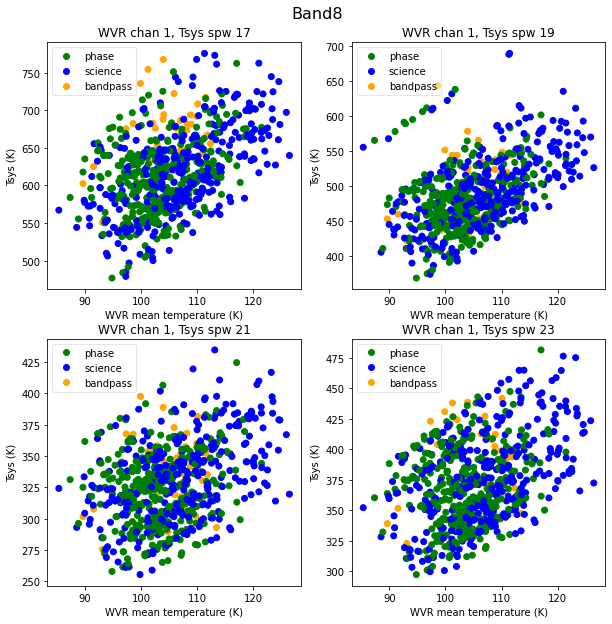

In [6]:
WVR_sinchan = WVR[:,1]
fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_sinchan, Tsys_sinspw, c=map_series_by_dict(obs_type, color_dict))

    # title
    title = 'WVR chan 1, Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('WVR mean temperature (K)')
    plt.ylabel('Tsys (K)')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)
    
fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_correlation.pdf', bbox_inches='tight', pad_inches=0.0)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


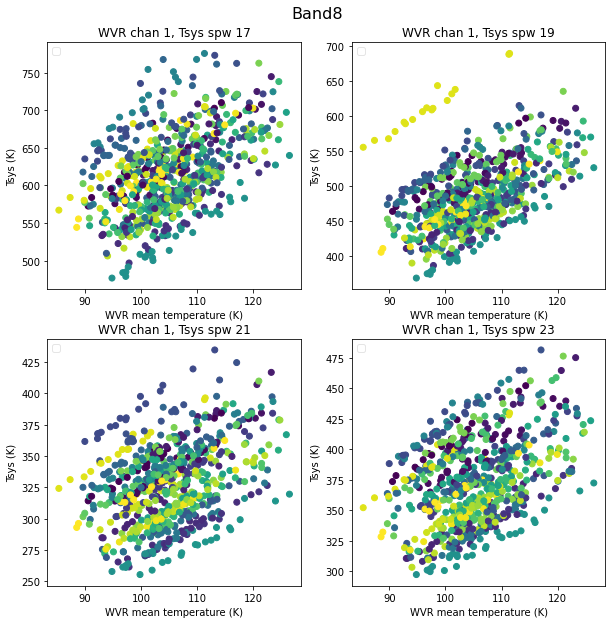

In [7]:
WVR_sinchan = WVR[:,1]
fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_sinchan, Tsys_sinspw, c=iants)

    # title
    title = 'WVR chan 1, Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('WVR mean temperature (K)')
    plt.ylabel('Tsys (K)')
    plt.legend(loc='upper left', framealpha=0.5)
    
fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_correlation_antscolor.pdf', bbox_inches='tight', pad_inches=0.0)

#### Normalized Tsys versus WVR

Normalize the Tsys and WVR value to the first of the measurement for each antenna

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.86984742 0.12751375] [0.01454028]
[ 1.0403295  -0.04038824] [0.01650762]
[0.81083044 0.18973107] [0.0133012]
[0.78149865 0.21800167] [0.01315971]


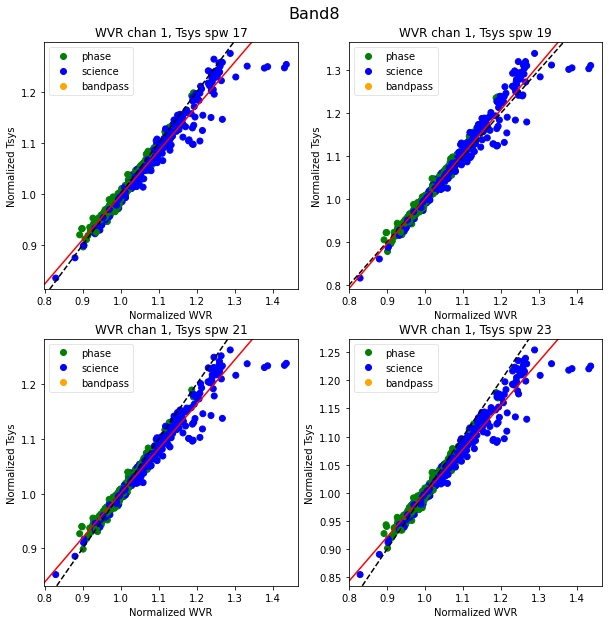

In [8]:
WVR_sinchan = WVR[:,3]
WVR_norm = normalize_array(WVR_sinchan, iants, obs_type, normScans=[0,0,0])
fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type, normScans=[0,0,0])
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_norm, Tsys_norm, c=map_series_by_dict(obs_type, color_dict))

    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')

    # fit the linear relation between normalized Tsys and WVR
    xdata = WVR_norm; ydata = Tsys_norm
    idx_nnan = ((~np.isnan(xdata)) & (~np.isnan(ydata)))
    fit_results = np.polyfit(xdata[idx_nnan], ydata[idx_nnan], 1, full=True)
    fit_coeff = fit_results[0]
    fit_err = fit_results[1]
    fit_err_rel = np.sqrt(fit_err / len(ydata[idx_nnan])) / np.mean(ydata[idx_nnan])
    ydata_fitted = fit_coeff[0] * xdata + fit_coeff[1]
    xlow = ax.set_xlim()[0]; xhigh = ax.set_xlim()[1]
    ylow = xlow * fit_coeff[0] + fit_coeff[1]; yhigh = xhigh * fit_coeff[0]+ fit_coeff[1]
    plt.plot([xlow, xhigh], [ylow, yhigh], color='red')
#     plt.plot(xdata, ydata_fitted, color='red', linestyle='dotted',
#             label=str(round(fit_coeff[0], 4))+'*x+'+str(round(fit_coeff[1], 4))
#             +'\n err: '+str(round(fit_err[0], 4)))

    print(fit_coeff, fit_err_rel)

    # title
    title = 'WVR chan 1, Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('Normalized WVR')
    plt.ylabel('Normalized Tsys')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_norm_correlation.pdf', bbox_inches='tight', pad_inches=0)

#### Normalize only to the science target

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.89585489 0.10604991] [0.01158805]
[ 1.07871931 -0.07914986] [0.01234255]
[0.84356117 0.15590327] [0.0086772]
[0.80969737 0.19052986] [0.00882296]


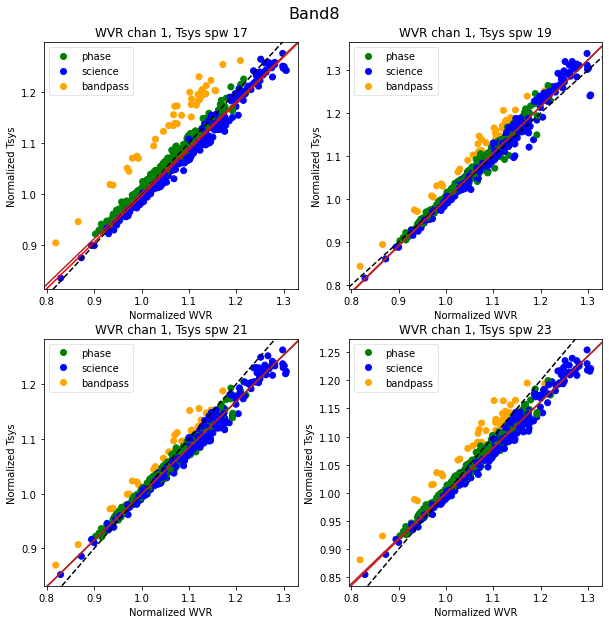

In [9]:
WVR_sinchan = WVR[:,1]
obs_type_temp = np.chararray(np.shape(obs_type), itemsize=10, unicode=False)
obs_type_temp[:] = 'science'
obs_type_temp = obs_type_temp.astype(str)
WVR_norm = normalize_array(WVR_sinchan, iants, obs_type_temp, normScans=[2])

fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type_temp, normScans=[2])
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_norm, Tsys_norm, c=map_series_by_dict(obs_type, color_dict))

    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')
    
    # plot the original fitted results
    slope = fit_table[17+2*i]['coeff'][0]
    intercept = fit_table[17+2*i]['coeff'][1]
    xlow = ax.set_xlim()[0]; xhigh = ax.set_xlim()[1]
    ylow = xlow * slope + intercept; yhigh = xhigh * slope + intercept
#     Tsys_norm_fitted_orig = slope * WVR_norm + intercept
    plt.plot([xlow, xhigh], [ylow, yhigh], color='red', linestyle='solid')

    # fit the linear relation between normalized Tsys and WVR
    xdata = WVR_norm; ydata = Tsys_norm
    # exclude the bandpass data in the fitting
    ydata[np.where(obs_type=='bandpass')] = np.nan
    
    idx_nnan = ((~np.isnan(xdata)) & (~np.isnan(ydata)))
    fit_results = np.polyfit(xdata[idx_nnan], ydata[idx_nnan], 1, full=True)
    fit_coeff = fit_results[0]
    fit_err = fit_results[1]
    fit_err_rel = np.sqrt(fit_err / len(ydata[idx_nnan])) / np.mean(ydata[idx_nnan])
#     ydata_fitted = fit_coeff[0] * xdata + fit_coeff[1]
    ylow = xlow * fit_coeff[0] + fit_coeff[1]; yhigh = xhigh * fit_coeff[0] + fit_coeff[1]                                                                                        
    plt.plot([xlow, xhigh], [ylow, yhigh], color='brown', linestyle='solid')

    print(fit_coeff, fit_err_rel)
    
    # title
    title = 'WVR chan 1, Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('Normalized WVR')
    plt.ylabel('Normalized Tsys')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_norm_correlation_sci.pdf', bbox_inches='tight', pad_inches=0)

#### Fewer Tsys versus WVR

Select a few Tsys instead of all the Tsys measurements

[ 5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21 21 21 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23
 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23 23]
0.01006599237050408
[0.92094488 0.0789948 ] [0.00702156]
0.011929631477245529
[ 1.10626838 -0.10455782] [0.01054677]
0.008604626584447033
[0.86157013 0.13975365] [0.00742978]
0.008563638976272055
[0.82973234 0.17102202] [0.00695092]


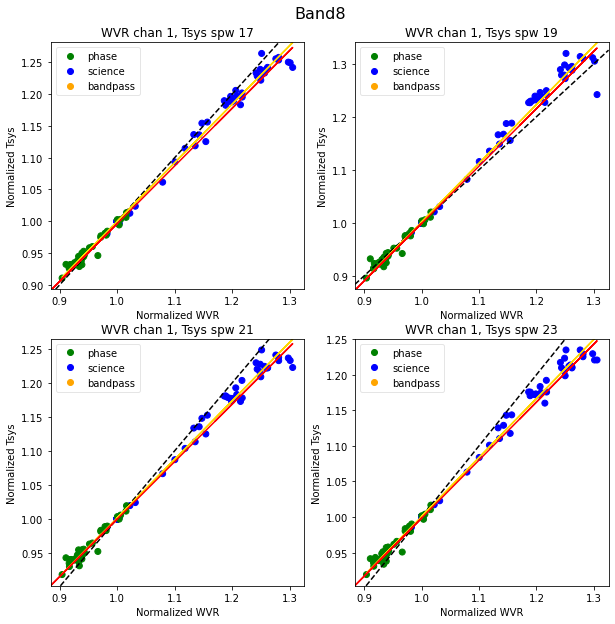

In [14]:
# select only a handful of ATM scans
WVR_sinchan = WVR[:,1]
WVR_norm = normalize_array(WVR_sinchan, iants, obs_type, normScans=[0,0,0])
ATM_ids = [1,2,8,9]
WVR_norm_few = select_array(WVR_norm, iants, ATM_ids)
scans_few = select_array(scans, iants, ATM_ids)
print(scans_few)

fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type, normScans=[0,0,0])
    Tsys_norm_few = select_array(Tsys_norm, iants, ATM_ids)
    obs_type_few = select_array(obs_type, iants, ATM_ids)
    
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_norm_few, Tsys_norm_few, c=map_series_by_dict(obs_type_few, color_dict))

    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')

    # fit the linear relation between normalized Tsys and WVR
    xdata = WVR_norm_few; ydata = Tsys_norm_few
    idx_nnan = ((~np.isnan(xdata)) & (~np.isnan(ydata)))
    fit_results = np.polyfit(xdata[idx_nnan], ydata[idx_nnan], 1, full=True)
    fit_coeff = fit_results[0]
    fit_err = fit_results[1]
    fit_err_rel = np.sqrt(fit_err / len(ydata[idx_nnan])) / np.mean(ydata[idx_nnan])
    ydata_fitted = fit_coeff[0] * xdata + fit_coeff[1]

    Tsys_ext_norm = fit_coeff[0] * WVR_norm + fit_coeff[1]
    scatter = np.sqrt(np.nanmean((Tsys_ext_norm-Tsys_norm)**2)) / np.nanmean(Tsys_norm)
    print(scatter)
    
    plt.plot(xdata, ydata_fitted, color='gold', linestyle='solid',
            label=str(round(fit_coeff[0], 4))+'*x+'+str(round(fit_coeff[1], 4))
            +'\n err: '+str(round(fit_err[0], 4)))

    print(fit_coeff, fit_err_rel)
    
    # plot the original fitted results
    slope = fit_table[17+2*i]['coeff'][0]
    intercept = fit_table[17+2*i]['coeff'][1]
    Tsys_norm_fitted_orig = slope * WVR_norm + intercept
    plt.plot(WVR_norm, Tsys_norm_fitted_orig, color='red', linestyle='solid')

    # title
    title = 'WVR chan 1, Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('Normalized WVR')
    plt.ylabel('Normalized Tsys')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_norm_part_correlation.pdf', bbox_inches='tight', pad_inches=0)

#### Try different WVR channels

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[ 1.52321972 -0.52588968] [0.01002979]
[0.9077614  0.08837185] [0.00907695]
[0.85118797 0.14500343] [0.00996651]
[0.86984742 0.12751375] [0.01454028]


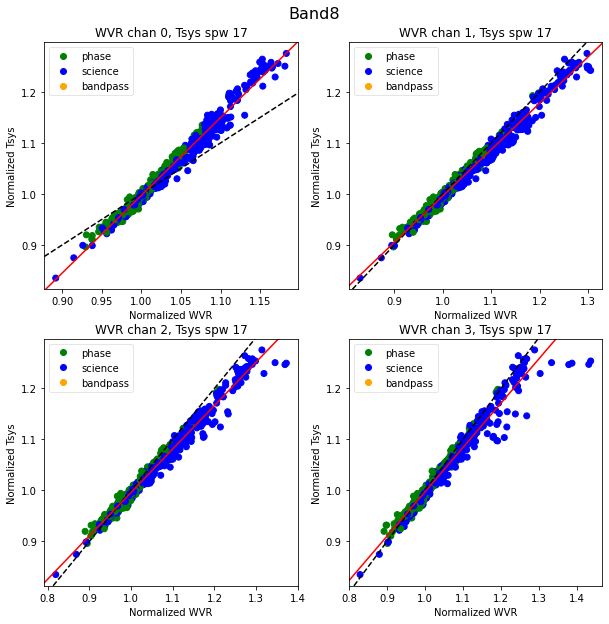

In [11]:
filename = 'Tsys_WVR_matched_avgTime10.pkl'
# load the data
with open (filename, 'rb') as pickle_file:
    Tsys_table = pickle.load(pickle_file, encoding='latin')
WVR = Tsys_table['WVR_means']

Tsys_sinspw = Tsys[:,0]
Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type, normScans=[0,0,0])

fig = plt.figure(figsize=(10,10))
for i in range(4):
    WVR_sinchan = WVR[:,i]
    WVR_norm = normalize_array(WVR_sinchan, iants, obs_type, normScans=[0,0,0])
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(WVR_norm, Tsys_norm, c=map_series_by_dict(obs_type, color_dict))

    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')

    # fit the linear relation between normalized Tsys and WVR
    xdata = WVR_norm; ydata = Tsys_norm
    idx_nnan = ((~np.isnan(xdata)) & (~np.isnan(ydata)))
    fit_results = np.polyfit(xdata[idx_nnan], ydata[idx_nnan], 1, full=True)
    fit_coeff = fit_results[0]
    fit_err = fit_results[1]
    fit_err_rel = np.sqrt(fit_err / len(ydata[idx_nnan])) / np.mean(ydata[idx_nnan])
    ydata_fitted = fit_coeff[0] * xdata + fit_coeff[1]
    xlow = ax.set_xlim()[0]; xhigh = ax.set_xlim()[1]
    ylow = xlow * fit_coeff[0] + fit_coeff[1]; yhigh = xhigh * fit_coeff[0]+ fit_coeff[1]
    plt.plot([xlow, xhigh], [ylow, yhigh], color='red')
#     plt.plot(xdata, ydata_fitted, color='red', linestyle='dotted',
#             label=str(round(fit_coeff[0], 4))+'*x+'+str(round(fit_coeff[1], 4))
#             +'\n err: '+str(round(fit_err[0], 4)))

    print(fit_coeff, fit_err_rel)

    # title
    title = 'WVR chan '+str(i)+', Tsys spw 17'
    plt.title(title)

    # label
    plt.xlabel('Normalized WVR')
    plt.ylabel('Normalized Tsys')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_WVR_norm_chans.pdf',bbox_inches='tight',pad_inches=0)

#### Calculate the PWV values

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.61640215 0.3793694 ] [0.00787586]
[0.73671193 0.26135936] [0.00856079]
[0.57459145 0.42448762] [0.00686382]
[0.55408257 0.44397162] [0.00689834]


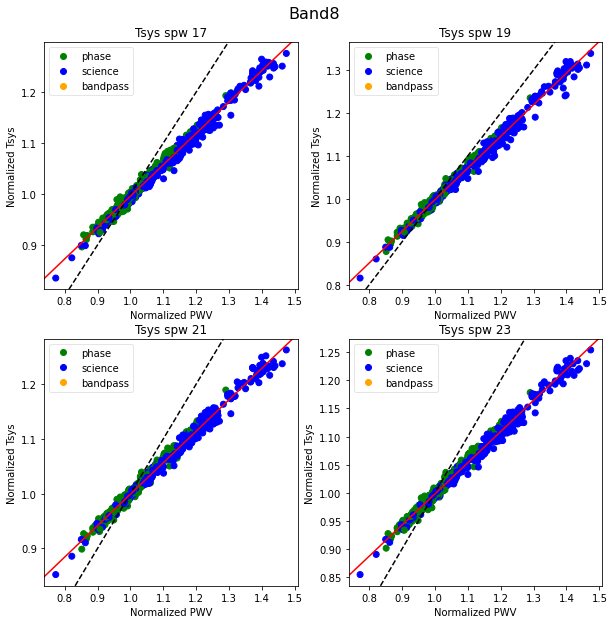

In [12]:
PWVs = np.array([])
for WVR_value in WVR:
    PWV = approxCalc(WVR_value[0],WVR_value[1],WVR_value[2],WVR_value[3],
                          m_el=53,Tamb=275,r=[1.193,0.399,0.176,0.115],
                          tau0=[0.027,0.02,0.01,0.01],eta_c=0.97,verb=False)
    PWVs = np.append(PWVs, PWV)
    
# normalize PWV and Tsys 
PWV_norms = normalize_array(PWVs, iants, obs_type, normScans=[0,0,0])

fig = plt.figure(figsize=(10,10))
for i in range(4):
    Tsys_sinspw = Tsys[:,i]
    Tsys_norm = normalize_array(Tsys_sinspw, iants, obs_type, normScans=[0,0,0])
    ax = fig.add_subplot(2,2,i+1)

    # create color dictionary for the scatter plot
    color_dict = { 'phase':'green', 'science':'blue', 'bandpass':'orange'}
    # color_dict["Mean relative error "+str(round(err_rel,4))] = 'black'
    legendhandle = [plt.plot([], marker="o", ls="", color=color)[0] for color in list(color_dict.values())]

    # plot the scatter plot
    sc = ax.scatter(PWV_norms, Tsys_norm, c=map_series_by_dict(obs_type, color_dict))

    # plot the 1-to-1 line
    lower=max(ax.set_xlim()[0], ax.set_ylim()[0])
    upper=min(ax.set_xlim()[1], ax.set_ylim()[1])
    ax.plot([lower, upper],[lower,upper],ls='--', color='black')

    # fit the linear relation between normalized Tsys and WVR
    xdata = PWV_norms; ydata = Tsys_norm
    idx_nnan = ((~np.isnan(xdata)) & (~np.isnan(ydata)))
    fit_results = np.polyfit(xdata[idx_nnan], ydata[idx_nnan], 1, full=True)
    fit_coeff = fit_results[0]
    fit_err = fit_results[1]
    fit_err_rel = np.sqrt(fit_err / len(ydata[idx_nnan])) / np.mean(ydata[idx_nnan])
    ydata_fitted = fit_coeff[0] * xdata + fit_coeff[1]
    xlow = ax.set_xlim()[0]; xhigh = ax.set_xlim()[1]
    ylow = xlow * fit_coeff[0] + fit_coeff[1]; yhigh = xhigh * fit_coeff[0]+ fit_coeff[1]
    plt.plot([xlow, xhigh], [ylow, yhigh], color='red')
#     plt.plot(xdata, ydata_fitted, color='red', linestyle='dotted',
#             label=str(round(fit_coeff[0], 4))+'*x+'+str(round(fit_coeff[1], 4))
#             +'\n err: '+str(round(fit_err[0], 4)))

    print(fit_coeff, fit_err_rel)

    # title
    title = 'Tsys spw '+str(Tsys_spws[i])
    plt.title(title)

    # label
    plt.xlabel('Normalized PWV')
    plt.ylabel('Normalized Tsys')
    plt.legend(loc='upper left', framealpha=0.5)
    plt.legend(legendhandle,list(color_dict.keys()), loc='upper left', framealpha=0.5)

fig.suptitle('Band8', fontsize=16, y=0.93)
plt.savefig(picDir+'2018.1.01778.S/Tsys_PWVs_norm.pdf',bbox_inches='tight',pad_inches=0)